<a href="https://colab.research.google.com/github/kuds/rl-car-racing/blob/main/%5BCar%20Racing%5D%20Proximal%20Policy%20Optimization%20(PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimitization (PPO)

In [1]:
!pip install swig

In [2]:
!pip install stable_baselines3 gymnasium[box2d]

In [3]:
import gymnasium
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.atari_wrappers import WarpFrame
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecTransposeImage
from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback

import os
import torch
import numpy
import platform
import stable_baselines3
import matplotlib
import matplotlib.pyplot
from platform import python_version
from importlib.metadata import version

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
if torch.cuda.is_available(): print(f"GPU Device: {torch.cuda.get_device_name(0)}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Scipy Version: {version('scipy')}")
print(f"Swig Version: {version('swig')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"IPython Version: {version('ipython')}")

Python Version: 3.12.11
Torch Version: 2.8.0+cu126
Is Cuda Available: True
Cuda Version: 12.6
GPU Device: NVIDIA L4
Gymnasium Version: 1.2.1
Numpy Version: 2.0.2
Scipy Version: 1.16.2
Swig Version: 4.3.1.post0
Stable Baselines3 Version: 2.7.0
IPython Version: 7.34.0


In [5]:
env_str = "CarRacing-v3"
log_dir = "./logs/{}".format(env_str)
name_prefix = "car_racing"
gray_scale = True

# If gray_scale True, convert obs to gray scale 84 x 84 image
wrapper_class = WarpFrame if gray_scale else None

In [6]:
env = gymnasium.make('CarRacing-v3')
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to 

Observation Space Size:  (96, 96, 3)
Action Space Size:  (3,)


In [7]:
# Create Training environment
env = make_vec_env(env_str,
                   n_envs=1,
                   wrapper_class=wrapper_class,
                   monitor_dir=os.path.join(log_dir, "monitor"))
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Create Evaluation environment
env_val = make_vec_env(env_str, n_envs=1, wrapper_class=wrapper_class)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

In [8]:
# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_freq = 50_000

eval_callback = EvalCallback(
    env_val,
    best_model_save_path=log_dir,
    log_path=log_dir,
    eval_freq=eval_freq,
    render=False,
    deterministic=True,
    n_eval_episodes=20)

checkpoint_callback = CheckpointCallback(
    save_freq=eval_freq,
    save_path=os.path.join(log_dir, "checkpoint")
)

# Create the callback list
callbackList = CallbackList([checkpoint_callback,
                             eval_callback])

In [9]:
# Initialize PPO
# ent_coef - encourages exploration of other actins
model = PPO('CnnPolicy',
            env,
            verbose=0,
            ent_coef=0.0075,
            tensorboard_log=os.path.join(log_dir, "tensorboard"))

# Train the model
model.learn(total_timesteps=1_000_000,
            progress_bar=False,
            callback=callbackList)

Eval num_timesteps=25000, episode_reward=-8.12 +/- 13.02
Episode length: 1000.00 +/- 0.00
New best mean reward!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Eval num_timesteps=50000, episode_reward=-31.28 +/- 38.30
Episode length: 291.30 +/- 41.42
Eval num_timesteps=75000, episode_reward=237.82 +/- 115.01
Episode length: 909.15 +/- 183.81
New best mean reward!
Eval num_timesteps=100000, episode_reward=240.04 +/- 97.48
Episode length: 983.65 +/- 55.71
New best mean reward!
Eval num_timesteps=125000, episode_reward=391.01 +/- 195.46
Episode length: 959.90 +/- 162.83
New best mean reward!
Eval num_timesteps=150000, episode_reward=594.15 +/- 247.06
Episode length: 962.75 +/- 123.94
New best mean reward!
Eval num_timesteps=175000, episode_reward=324.56 +/- 214.54
Episode length: 914.10 +/- 237.03
Eval num_timesteps=200000, episode_reward=140.52 +/- 177.01
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=225000, episode_reward=701.45 +/- 212.21
Episode length: 992.70 +/- 31.82
New best mean reward!
Eval num_timesteps=250000, episode_reward=774.85 +/- 114.32
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=275000, epis

In [10]:
# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Final Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Mean reward: 842.84 +/- 114.12


In [11]:
# Create Evaluation environment
env = make_vec_env(env_str, n_envs=1, seed=0, wrapper_class=wrapper_class)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Car Racing
best_model_file_name = "best_model_{}".format(name_prefix)
env = VecVideoRecorder(env,
                       log_dir,
                       video_length=5_000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix=best_model_file_name)

obs = env.reset()
for _ in range(5_000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

Best Model - Mean reward: 873.76 +/- 48.43


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/logs/CarRacing-v3/best_model_car_racing-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/logs/CarRacing-v3/best_model_car_racing-step-0-to-step-5000.mp4



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Moviepy - Done !
Moviepy - video ready /content/logs/CarRacing-v3/best_model_car_racing-step-0-to-step-5000.mp4


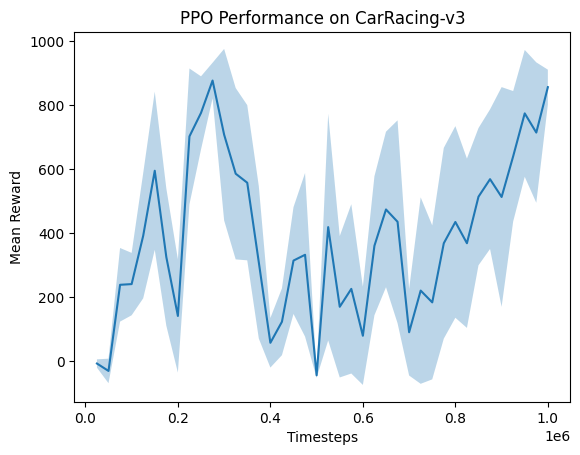

In [12]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"PPO Performance on {env_str}")
matplotlib.pyplot.show()